Using Theano backend.


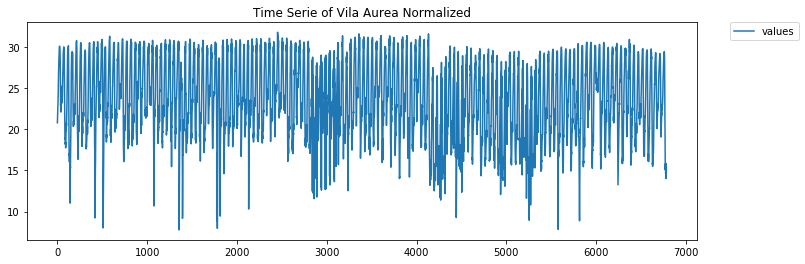

In [1]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import time
import datetime
import scipy
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from estatisticas_time_serie import create_dataset, general_forecasting
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error

# load the first dataset vilacarvalho-vazao-60
dataframe = pandas.read_csv('735g-pressaomedia-vila-aurea-4meses.csv', engine='python', skipfooter=3)
timeValues = dataframe['Time']
values     = dataframe['Value']

newV=[]
for i in values:
    if not i == 'null': 
        newV.append(float(i))

newV = np.array(newV)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
newV = reject_outliers(newV)

timestamps=[]
for idx,i in enumerate(timeValues):
    # skipping null values
    if not values[idx] == 'null':
        val = time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
        timestamps.append([val])


plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie of Vila Aurea Normalized')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [2]:
# splitting data
train_size = int(len(newV) * 0.8)
test_size = len(newV) - train_size
train, test = newV[0:train_size], newV[train_size:train_size+test_size]
print(len(train), len(test))

(5423, 1356)


In [3]:
# create dataset 
# Using  KNN
look_back = 48
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Ssing lstm
scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstmTrain = scaler.fit_transform(train)
datasetLstmTest = scaler.fit_transform(test)
look_back = 48
trainX_lstm, trainY_lstm = create_dataset(datasetLstmTrain, look_back)
testX_lstm, testY_lstm = create_dataset(datasetLstmTest, look_back)
# reshape input to be [samples, time steps, features]
trainX_lstm = np.reshape(trainX_lstm, (trainX_lstm.shape[0], 1, trainX_lstm.shape[1]))
testX_lstm = np.reshape(testX_lstm, (testX_lstm.shape[0], 1, testX_lstm.shape[1]))

# using ARIMA
s = pd.Series(train, index=timeValues[0:train_size])


In [4]:
#train the models
# KNN
clf_KNN = KNeighborsRegressor(n_neighbors=1)
clf_KNN.fit(trainX, trainY)

# SVM
clf_SVM = SVR()
params_list = {"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
#n_iter_search=10
random_search = RandomizedSearchCV(clf_SVM, param_distributions=params_list,
                                   n_iter=5)
random_search.fit(trainX, trainY)
clf_SVM = random_search.best_estimator_

#LSTM
model = Sequential()
model.add(LSTM(10, input_dim=look_back))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX_lstm, trainY_lstm, nb_epoch=49, batch_size=128, verbose=0)
# Arima

In [5]:
#predicting
forecast_KNN = general_forecasting(testX, clf_KNN, size_forecasting=48 , strategy_approach='retro')
forecast_LSTM = general_forecasting(testX_lstm, model, size_forecasting=48, strategy_approach='retro')
forecast_SVM =  general_forecasting(testX, clf_SVM, size_forecasting=48, strategy_approach='retro')
forecastedArima = general_forecasting(test,train=s.values,size_forecasting=48 ,classifier=None, strategy_approach='retro')

In [6]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)
testY_lstm = scaler.inverse_transform(testY_lstm)

In [9]:
#errors
print("mean_squared_error  KNN = ",mean_squared_error(trainY[:48],forecast_KNN))
print("mean_squared_error  SVM = ",mean_squared_error(trainY[:48],forecast_SVM))
print("mean_squared_error  LSTM = ",mean_squared_error(testY_lstm[:48],forecast_LSTM))
print("mean_squared_error  ARIMA = ",mean_squared_error(test[:48],forecastedArima))

('mean_squared_error  KNN = ', 59.564359275349567)
('mean_squared_error  SVM = ', 18.809649954661314)
('mean_squared_error  LSTM = ', 0.5523723342945428)
('mean_squared_error  ARIMA = ', 5.7958957263362647)


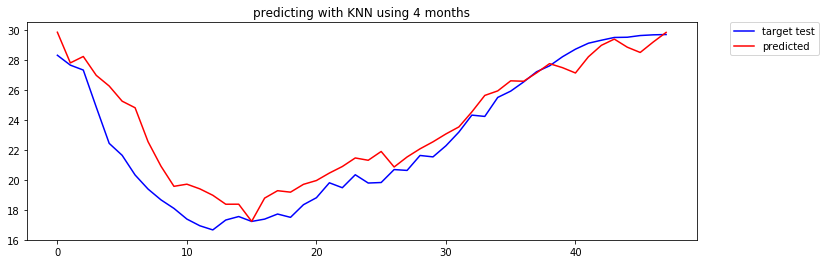

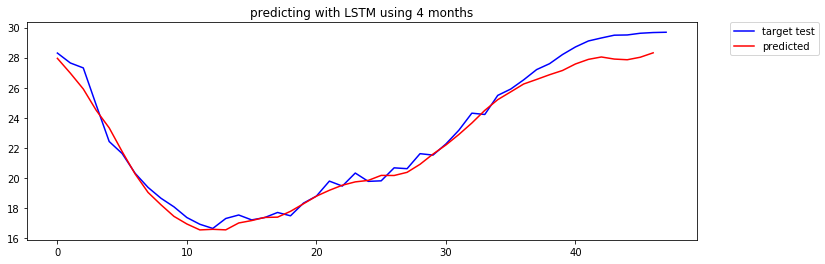

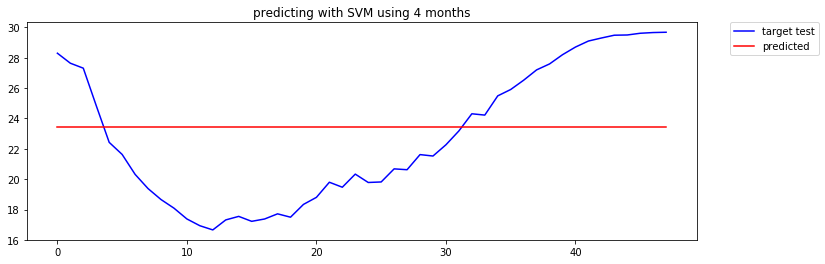

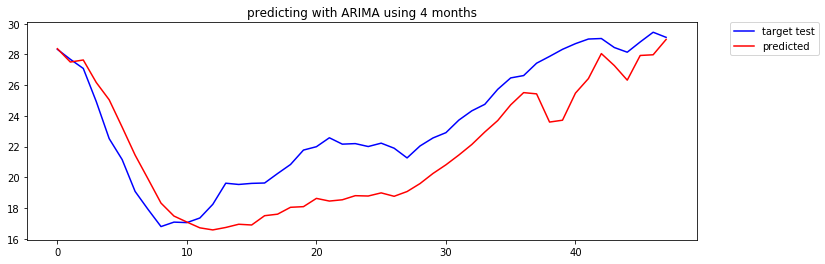

In [11]:
#### plotting knn results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[0:48],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with KNN using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:-1]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY_lstm[:48],color='b',label='target test')
plt.plot(testPredictPlot[:48], color='r', label='predicted')
plt.title('predicting with LSTM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plotting svm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_SVM

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[:48],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with SVM using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


#plotting arima results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecastedArima

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test[:48],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with ARIMA using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()